# Kraken2 annotation 

Kraken2 is a taxonomic classification system that uses short genomic substrings (k-mer) matches. The k-mer is matched within a query sequence with the lowest common ancestor of all genomes containing the exact k-mer. Kraken is fast and provides a taxa report for each sample. To read more about Kraken2 and install the tool visit github.com/DerrickWood/kraken2/wiki. 

This step is on Carbonate, a supercomputer, because the data set was too large to transfer to a Jetstream VM. It is possible to do this step on Jetstream, if a larger volume is requested and attached. This script will align reads against the kraken database to find the taxa. In this case, I am using sediment metagenome data sampled from hydrocarbon seepages in the Gulf of Mexico and identifying taxa families. Taxa identification is necessary to find species richness later for the rarefaction curve. Rarefaction curves are described later, after the taxa is identified and generated into a .csv table. 


## Carbonate

In [ ]:
#on Carbonate load kraken
module load kraken

In [ ]:
#aligns reads against DB for each metagenome sample
#on Carbonate in interactive computer node 
kraken2 --db $KRAKEN_DB --use-names --report-zero-counts --paired "$f"_1.fq "$f"_2.fq --report "$f"_kraken_report 

Looking at the command above, the input samples are the forward and reverse read of the sample. Only one sample can be ran at a time using this command. This command will generate a report with the specified parameters (use-names, report-zero-counts, paired) for the sample as output. More information about Kraken2 parameters are described in the manual. The output, "$f"_kraken_report generates a table that looks like

Sample Name | % of aligned reads | # of reads covered by clade | # of reads assigned to this taxa | rank code | NCBI Taxa ID
------------ | ------------- | ------------ | ------------- | ------------- | ------------- 
Content from cell 1 | Content from cell 2 | cell 3 | cell 4 | cell 5 | cell 6 
Content in the first column | Content in the second column | third | fourth | fifth | six 
Content in the first column | Content in the second column | third | fourth | fifth | six 
Content in the first column | Content in the second column | third | fourth | fifth | six 

Since every output is in a separate table, we need to combine them to make a rarefaction curve later. To prepare for this step, all kraken reports should be placed in thier own directory. 

In [ ]:
#put all reports into one directory
mkdir kraken_report
mv *_kraken_report FILEPATH/kraken_report/

In [ ]:
#combine each report into one table using kraken
#clone girhub kraken2-output
git clone https://github.com/npbhavya/Kraken2-output-manipulation.git

In [ ]:
#load python 3 
module unload python/2
module load python/3

The following command is used to get taxa information instead of taxa ID. The input -d for script the directory of kraken reports for each sample. 
-r defines taxonomic rank: (U)nclassified, (R)oot, (D)omain, (K)ingdom, (P)hylum, (C)lass, (O)rder, (F)amily, (G)enus, or (S)pecies
-c defines the column to be included in the final report col1: number of reads covered; col2: percentage of reads covered by taxa
-o output, defines output file name

The output is a table of taxa families followed by numbers that will look something like:

Taxa    ['sample1', 'sample2', 'sample3', 'sample4', 'sample5', 'sample6', 'sample7']

Pseudomonadaceae        ['78249', '103170', '81428', '76970', '75855', '69162', '92573']

Moraxellaceae   ['9420', '6299', '10383', '10311', '6685', '3269', '9622']

Enterobacteriaceae      ['31660', '27116', '34082', '31873', '24965', '16778', '33615']


This step was run again using a different rank (Phylum) and using percentages for the alluvial plot. kraken_reports_phylum.csv

In [ ]:
#get taxa information into a table (in git hub clone)
python kraken-multiple-taxa.py -d kraken_report/ -r F -c 1 -o kraken-report-final

In [ ]:
#generate .csv for R 
sed -e "s/\[//g;s/\]//g;s/'//g;s|\t|,|g" kraken-report-final >kraken_report_final_table.csv

The output for the csv file command should look like a table. This table is now ready to be imported to Jetstream to use in R. 

## Jetstream

A medium Ubuntu 18.04 instance was launched and Jupyter notebooks was installed following https://blogs.iu.edu/ncgas/2020/06/15/installing-jupyter-notebook-on-jetstream/. Select a instance size depending on your dataset. In additon, a 100 GB volume was attached. Request a larger volume if needed. The final kraken report in .csv format was transferred to the volume. 

In [ ]:
#on Jetstream to transfer table to VM 
sudo scp hleffler@carbonate.uits.iu.edu:/N/dc2/scratch/hleffler/Kraken2-output-manipulation/kraken_report_final_taxa_table.csv .

In [ ]:
#download Rscripts
git clone https://github.com/npbhavya/Kraken2-output-manipulation.git

Now the table should be copied to the volume and the scripts downloaded

# Rarefraction curve 

A rarefaction curve shows species richness of a sample to determine if a sample is representative of a larger population by plotting the sample size and species. A rarefaction curve showing a respresentative sample will grow rapidly and then slowly plateau. The rapid growth shows how every read in the sample identifies as a new organism and the plateau shows the rare species in the sample that remain to be sampled. If your samples do not reach a plateau, it is suggested that most species in the sample are rare; Increasing the sample size will create a better respresentation of the larger population.   
In regard to our data, we are making a rarefaction curve to determine if the sediment metagenome samples are respresentative of the larger population in the GOM.

Before plotting a rarefaction curve, it is necessary to identify taxa using Kraken2 or another taxa identification tool because this information is neccessary to calculate species richness. The .csv table generated from the kraken reports will be used. The input for the table will be read as a table, but then transposed and read as a data frame for the rarefaction curve. 

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



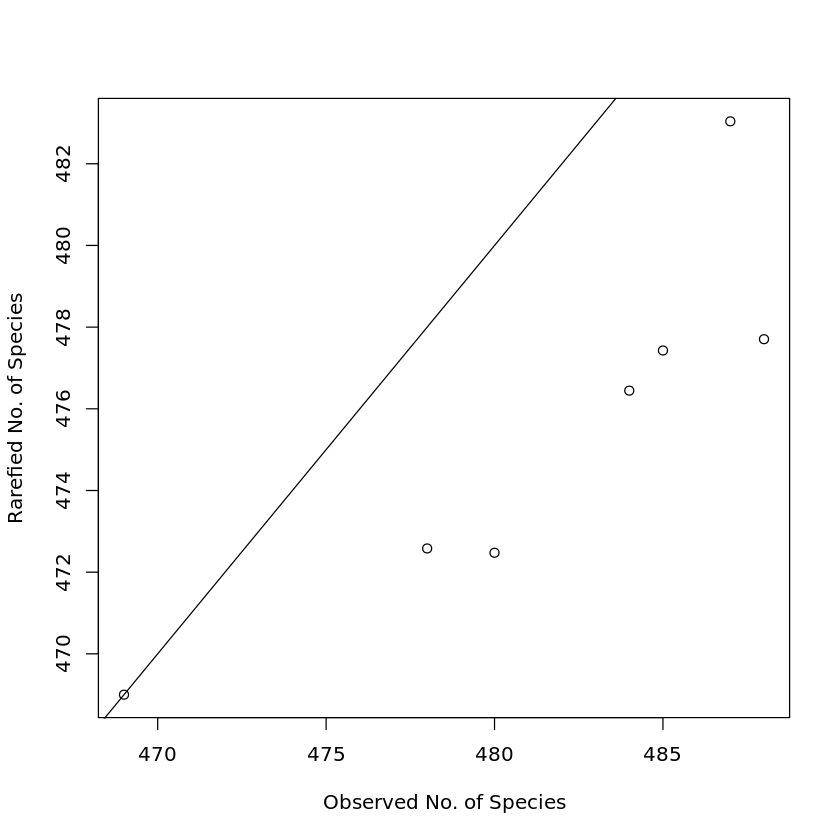

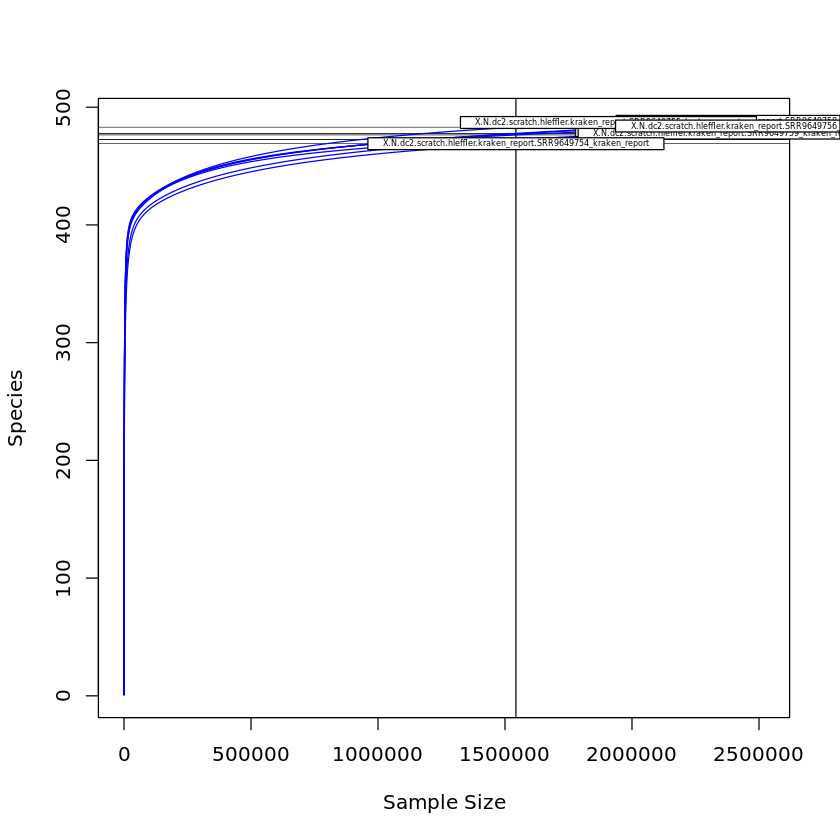

In [10]:
#install.packages("vegan");
library(vegan);

#importing the file and parsing the file correctly
#Replace the kraken.csv name to the actual filename.
Data=read.table("kraken_report_final_taxa_table.csv", sep=",", row.names = 1, header=TRUE);
Data_t=as.data.frame(t(Data));
#print(Data_t);


#count the number of species
S = specnumber(Data_t);
raremax = min(rowSums(Data_t));
#print(S);
#print(raremax);

#Rarefaction of the samples
Srare = rarefy(Data_t, raremax);
#print(Srare);

#plotting the rarefaction curves
plot(S, Srare, xlab = "Observed No. of Species", ylab = "Rarefied No. of Species")
abline(0, 1)
#pdf("Rarefaction_curve.pdf")
rarecurve(Data_t, step =20, sample = raremax, col = "blue", cex = 0.4, )
#dev.off()

Looking at the rarefaction curve calculated using the samples from the GOM above, the curve grows rapidly and then plateaus. The plateau in the graph shows that no new species are being identified in the samples. This graph shows that the seven samples taken is a representative sample of the larger population. Great. 

# PCA plots

A principal component analysis (PCA) is a type of ordination plot. Ordination plots summarize data by reducing the dimensions, or variables, and plotting the samples in a format that can be visualized. A PCA plot shows the direction of maximal variation between multiple variables by condensing them into new variables, called principal components, in a data set without compromising information. A PCA plot reduces the dimensions of a matrix to show how similar or dissimilar samples are based on their distance and grouping of each other.

### Installations
In preparation to make an ordination plot using devtools, several dependency packages also must installed. On the version of R I am using (3.4.4), the libraries for these packages are not installed. This is because it is a older version of R. The step of installing dependecy libraries in the terminal with file path to the library is neccessary or devtools will not install properly and the script won't work. 

In [11]:
#PCA
#dependencies for devtools package
 #before installing these packages must have these commands ran in terminal file path: ~/R/USERNAME/R/x86_64-pc-linux-gnu-library/3.4
    #sudo apt-get install -y libcurl4-openssl-dev
    #sudo apt-get install libssl-dev
    #sudo apt-get install libxml2
    #sudo apt-get install libxml2-dev
#install.packages("curl", lib="/home/hleffler/R/x86_64-pc-linux-gnu-library/3.4");
#install.packages("gh");
#install.packages("xml2");
#install.packages("usethis");
#install.packages("covr");
#install.packages("roxygen2");
#install.packages("rversions");

#update.packages("devtools")
#install.packages("devtools");
library(devtools);
#install_github("vqv/ggbiplot") #to install the ggbiplot
library(ggbiplot);


Loading required package: usethis


Attaching package: ‘devtools’


The following object is masked from ‘package:permute’:

    check


Loading required package: plyr

Loading required package: scales

Loading required package: grid



notes -- script to work on 

In [13]:
#step to remove the variables without a lot of variance
#apply returns list of values, var is variance of x na.rm remove missing values, not equal to 0
Srare_clean=Srare[,apply(Srare, 2,var, na.rm=TRUE)!=0]


#print(Srare)
#print(Srare_clean)

data.pca=prcomp(Srare_clean, center = TRUE)
summary(data.pca)
#View(data.pca)

ggbiplot(data.pca)
location=c("seep2","ref","seep1","seep2","seep1","ref","seep1")
ggbiplot(data.pca, varname.size = 0, ellipse = TRUE, groups = location, circle = TRUE)


ERROR: Error in array(Srare, 2, var): 'dimnames' must be a list


## Alluvial plot
An alluvial plot is similar to a sankey diagram. Alluvial plots show how sets of groups change according to differnt dimensions. I am making this plot to show how the samples differ between each other. Or to show how each sample changes across the taxa families -- i am not sure yet. 

,Proteobacteria,Actinobacteria,Firmicutes,Planctomycetes,Bacteroidetes,Euryarchaeota,Other,Samples
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
SRR9649754,8.58,4.04,0.67,0.80,0.39,0.25,1.10,SRR9649754
SRR9649757,7.72,3.37,0.73,0.71,0.42,0.23,1.17,SRR9649757
SRR9649755,4.88,2.35,0.84,0.53,0.41,0.27,1.17,SRR9649755
SRR9649756,3.88,1.68,0.83,0.30,0.43,0.52,1.13,SRR9649756
SRR9649758,3.41,1.29,0.90,0.28,0.44,0.64,1.19,SRR9649758
SRR9649759,3.37,1.23,0.89,0.25,0.46,0.62,1.18,SRR9649759


Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”
Warning message in to_lodes_form(data = data, axes = axis_ind, discern = params$discern):
“Some strata appear at multiple axes.”


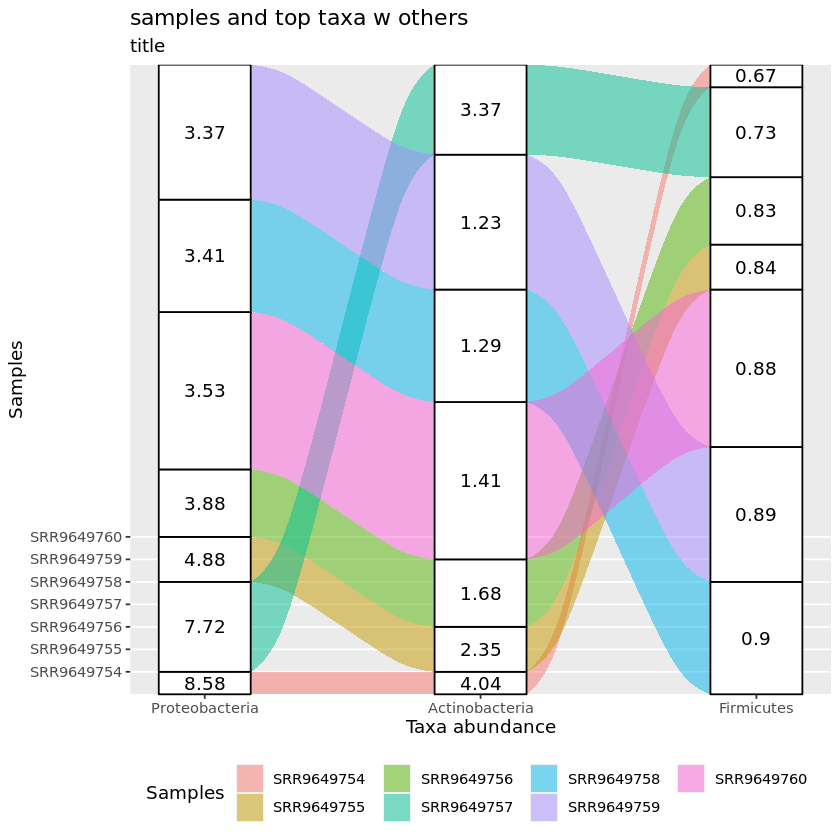

In [8]:
library(ggalluvial);
library(ggplot2);


#phylum_data=read.table("kraken_report_phylum_percent.csv", sep=",", header = TRUE)
phylum_cleaned=read.table("grouped_other.csv", sep=",", header = TRUE, row.names = 1)
#transpose data
tphylum = t(phylum_cleaned)

#read as dataframe and add column 
tphylum_wide = data.frame(tphylum)
tphylum_wide$Samples =(c("SRR9649754","SRR9649757","SRR9649755","SRR9649756","SRR9649758","SRR9649759","SRR9649760"))
#tphylum_wide$Location = (c("ref","ref","seep1","seep1","seep1","seep2","seep2"))
head(tphylum_wide)

#phylum_wide <- data.frame(phylum_data)

#alluvial plot
ggplot(data = tphylum_wide,
       aes(axis1 = Proteobacteria, axis2 = Actinobacteria, axis3 = Firmicutes,
           y = Samples)) +
  scale_x_discrete(limits = c("Proteobacteria", "Actinobacteria", "Firmicutes"), expand = c(.11, .05)) +
  xlab("Taxa abundance") +
  geom_alluvium(aes(fill = Samples)) +
  geom_stratum() + geom_text(stat = "stratum", infer.label = TRUE) +
  theme(legend.position = "bottom") +
  ggtitle("samples and top taxa w others",
          "title")